############################################################################################################################################

In [1]:
!pip install pydriller pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.6 MB/s eta 0:00:00


In [2]:

import os
import subprocess
REPO_LINKS = {
   "axios2": "https://github.com/pallets/flask.git",
    "Alamofire2": "https://github.com/psf/requests.git",
    "chains2": "https://github.com/All-Hands-AI/OpenHands.git"
}


BASE_DIR = "repos"
os.makedirs(BASE_DIR, exist_ok=True)

for name, url in REPO_LINKS.items():
    repo_path = os.path.join(BASE_DIR, name)
    if not os.path.exists(repo_path):
        print(f"Cloning {name} (full history) from {url} ...")
        subprocess.run(["git", "clone", "--no-single-branch", url, repo_path])
    else:
        print(f"Already exists: {name}")
        # Ensure full history in case it was shallow
        subprocess.run(["git", "-C", repo_path, "fetch", "--unshallow"], stderr=subprocess.DEVNULL)



Cloning axios2 (full history) from https://github.com/pallets/flask.git ...


Cloning into 'repos/axios2'...


Cloning Alamofire2 (full history) from https://github.com/psf/requests.git ...


Cloning into 'repos/Alamofire2'...


Cloning chains2 (full history) from https://github.com/All-Hands-AI/OpenHands.git ...


Cloning into 'repos/chains2'...



Processing axios2...
Saved processed dataset → diff_analysis_axios2.csv

Mismatch Report for axios2:
Source Code: 95
Test Code: 50
README: 1
LICENSE: 1


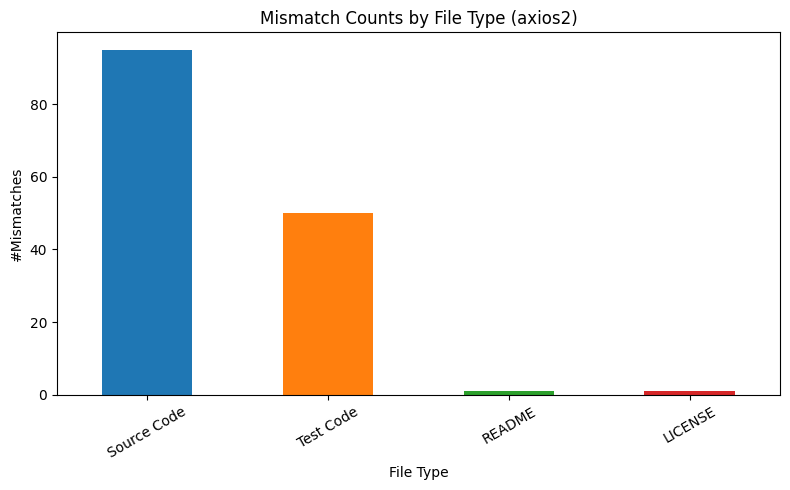


Processing Alamofire2...
Saved processed dataset → diff_analysis_Alamofire2.csv

Mismatch Report for Alamofire2:
Source Code: 125
Test Code: 29
README: 8
LICENSE: 0


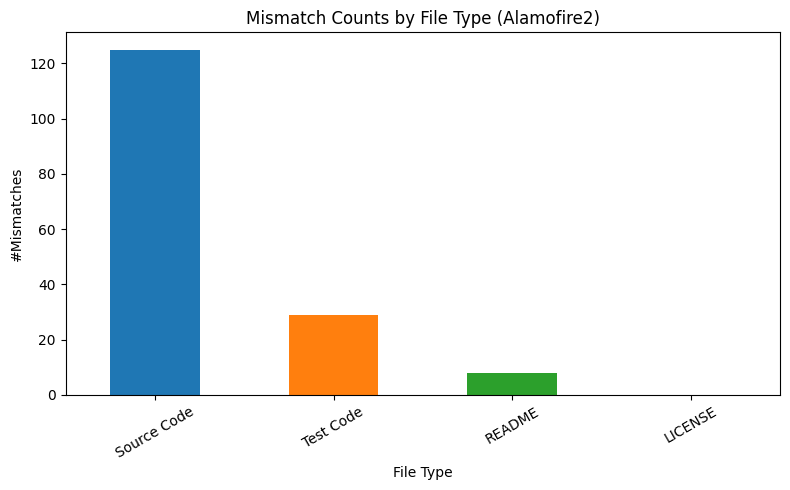


Processing chains2...
Saved processed dataset → diff_analysis_chains2.csv

Mismatch Report for chains2:
Source Code: 312
Test Code: 213
README: 34
LICENSE: 0


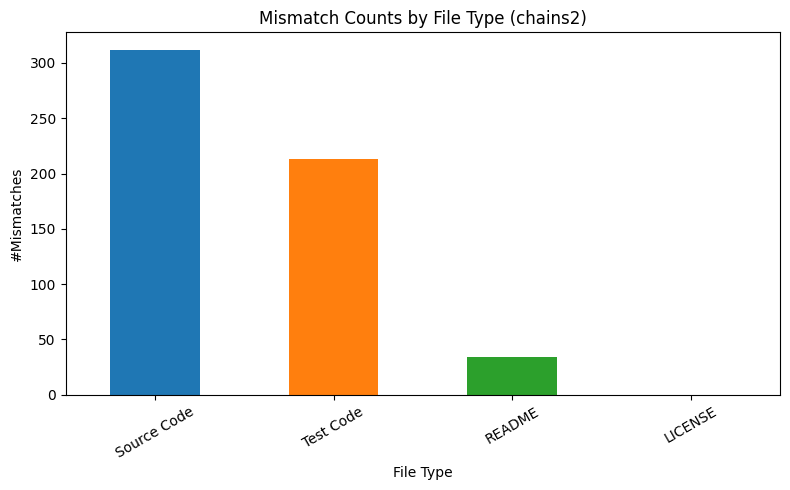

In [3]:
from pydriller import Repository
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os


# ---------- Step 1: Run git diff ----------
def git_diff(repo_path, parent_sha, sha, file_path, algorithm):
    """
    Run git diff with the specified algorithm (myers or histogram),
    ignoring whitespace and blank lines.
    """
    cmd = [
        "git", "-C", repo_path, "diff",
        f"--diff-algorithm={algorithm}",
        "-w", "--ignore-blank-lines",
        parent_sha, sha, "--", file_path
    ]
    result = subprocess.run(
        cmd, capture_output=True, text=True,
        encoding="utf-8", errors="replace", check=False
    )
    return result.stdout if result.stdout else ""


# ---------- Step 2: Normalize diff ----------
def normalize_diff(diff_text: str):
    if not isinstance(diff_text, str):
        return []

    lines = []
    for line in diff_text.splitlines():
        if line.startswith(("+++", "---", "index", "diff", "@@")):
            continue  # skip metadata
        if line.startswith("+") or line.startswith("-"):
            lines.append(line.strip())
    return lines


# ---------- Step 3: Compare diffs ----------
def compare_diffs(diff_myers: str, diff_hist: str) -> str:
    norm_myers = normalize_diff(diff_myers)
    norm_hist = normalize_diff(diff_hist)

    if not norm_myers and not norm_hist:
        return "No"   # both empty → no discrepancy

    return "No" if norm_myers == norm_hist else "Yes"


# ---------- Step 4: Classify file type ----------
def classify_file(path):
    if not isinstance(path, str) or path.strip() == "" or path.lower() == "nan":
        return "Other"

    path_lower = path.lower()
    filename = os.path.basename(path)

    if filename.lower().startswith("readme"):
        return "README"
    if filename.lower().startswith("license"):
        return "LICENSE"
    if "test" in path_lower or "tests" in path_lower:
        return "Test Code"
    if filename.endswith((".py", ".c", ".cpp", ".java", ".js", ".ts", ".rb", ".go", ".rs")):
        return "Source Code"
    return "Other"


# ---------- Step 5: Process a repo ----------
def process_repo(repo_path, repo_name, out_csv):
    print(f"\nProcessing {repo_name}...")

    records = []

    for commit in Repository(repo_path).traverse_commits():
        for mod in commit.modified_files:
            if not commit.parents:
                continue  # skip root commits

            old_path = mod.old_path
            new_path = mod.new_path
            file_path = new_path or old_path

            # Run diffs
            diff_myers = git_diff(repo_path, commit.parents[0], commit.hash, file_path, "myers")
            diff_hist = git_diff(repo_path, commit.parents[0], commit.hash, file_path, "histogram")

            records.append({
                "old_file_path": old_path,
                "new_file_path": new_path,
                "commit_SHA": commit.hash,
                "parent_commit_SHA": commit.parents[0],
                "commit_message": commit.msg,
                "diff_myers": diff_myers,
                "diff_hist": diff_hist,
                "Discrepancy": compare_diffs(diff_myers, diff_hist),
                "FileType": classify_file(file_path)
            })

    # Save processed dataset
    df = pd.DataFrame(records)
    df.to_csv(out_csv, index=False, encoding="utf-8")
    print(f"Saved processed dataset → {out_csv}")

    # Count mismatches by category
    mismatches = df[df["Discrepancy"] == "Yes"]
    counts = mismatches["FileType"].value_counts()

    # Print report
    print(f"\nMismatch Report for {repo_name}:")
    for category in ["Source Code", "Test Code", "README", "LICENSE"]:
        print(f"{category}: {counts.get(category, 0)}")

    # Plot bar chart
    plt.figure(figsize=(8, 5))
    counts = counts.reindex(["Source Code", "Test Code", "README", "LICENSE"], fill_value=0)
    counts.plot(kind="bar", color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])

    plt.title(f"Mismatch Counts by File Type ({repo_name})")
    plt.xlabel("File Type")
    plt.ylabel("#Mismatches")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


# ---------- Step 6: Run for three repos ----------
repos = {
       "axios2": "/kaggle/working/repos/axios2",
    "Alamofire2": "/kaggle/working/repos/Alamofire2",
    "chains2": "/kaggle/working/repos/chains2"
}

for repo_name, repo_path in repos.items():
    safe_name = repo_name.replace("/", "_")
    out_csv = f"diff_analysis_{safe_name}.csv"
    process_repo(repo_path, repo_name, out_csv)


In [27]:
import pandas as pd

repositories = ["axios2", "Alamofire2", "chains2"]

for name in repositories:
    file_path = f"/kaggle/working/diff_analysis_{name}.csv"
    df = pd.read_csv(file_path)

    # Add discrepancy column
    df["Discrepancy"] = df.apply(
        lambda row: "No" if str(row["diff_myers"]).strip() == str(row["diff_hist"]).strip() else "Yes",
        axis=1
    )

    # Save updated CSV
    df.to_csv(f"diff_analysis_{name}_with_discrepancy.csv", index=False)
    print(f"Updated file saved: diff_analysis_{name}_with_discrepancy.csv ✅")

Updated file saved: diff_analysis_axios2_with_discrepancy.csv ✅
Updated file saved: diff_analysis_Alamofire2_with_discrepancy.csv ✅
Updated file saved: diff_analysis_chains2_with_discrepancy.csv ✅


  old_file_path                                new_file_path  \
0           NaN                                   .gitignore   
1           NaN          examples/apishowcase/apishowcase.py   
2           NaN        examples/apishowcase/static/style.css   
3           NaN  examples/apishowcase/templates/counter.html   
4           NaN    examples/apishowcase/templates/hello.html   

                                 commit_SHA parent_commit_SHA  \
0  33850c0ebd23ae615e6823993d441f46d80b1ff0               NaN   
1  33850c0ebd23ae615e6823993d441f46d80b1ff0               NaN   
2  33850c0ebd23ae615e6823993d441f46d80b1ff0               NaN   
3  33850c0ebd23ae615e6823993d441f46d80b1ff0               NaN   
4  33850c0ebd23ae615e6823993d441f46d80b1ff0               NaN   

                                 commit_message  \
0  Initial checkin of stuff that exists so far.   
1  Initial checkin of stuff that exists so far.   
2  Initial checkin of stuff that exists so far.   
3  Initial checkin o

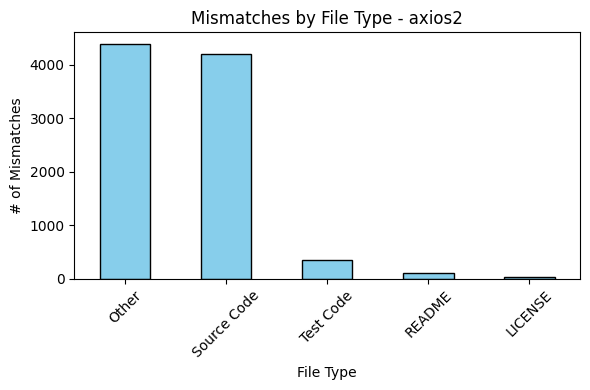

  old_file_path     new_file_path                                commit_SHA  \
0        README            README  e7615cbc6b4af5985c4e0d4848a426e2d35f79c3   
1        README            README  d0bf5538097cbdee663eddf4e29e9f34106c67cb   
2           NaN          setup.py  0477018761c67152cdcc0b83d56f27e701e65b9e   
3           NaN  test_requests.py  75b499dd046060021db0c7a772dd34df9374a30b   
4           NaN           LICENSE  c51b44d96bb460ebea3daee7deeff6b686585087   

                          parent_commit_SHA               commit_message  \
0                                       NaN                 first commit   
1  e7615cbc6b4af5985c4e0d4848a426e2d35f79c3                no mo of that   
2  d0bf5538097cbdee663eddf4e29e9f34106c67cb                easy setup.py   
3  0477018761c67152cdcc0b83d56f27e701e65b9e  sample test fixtures (none)   
4  75b499dd046060021db0c7a772dd34df9374a30b           ISC License by mee   

                                          diff_myers  \
0           

/tmp/ipykernel_36/4017937003.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatches["FileType"] = mismatches["new_file_path"].apply(categorize_file)


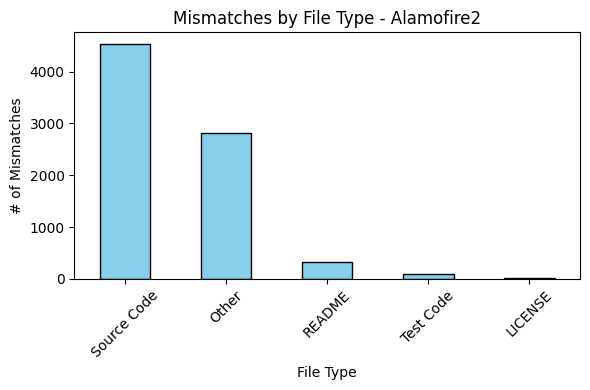

  old_file_path               new_file_path  \
0           NaN                   README.md   
1     README.md                   README.md   
2           NaN         frontend/.gitignore   
3           NaN          frontend/README.md   
4           NaN  frontend/package-lock.json   

                                 commit_SHA  \
0  7b63deba2df78a5980766ca3d5d79816f7ceee76   
1  d7b8013472b49638de031c46927a10bade1fcb12   
2  788ba686c9e98dac6a9ba6e7ae9b3cdbf86066d8   
3  788ba686c9e98dac6a9ba6e7ae9b3cdbf86066d8   
4  788ba686c9e98dac6a9ba6e7ae9b3cdbf86066d8   

                          parent_commit_SHA          commit_message  \
0                                       NaN           init: project   
1  7b63deba2df78a5980766ca3d5d79816f7ceee76          update: readme   
2  d7b8013472b49638de031c46927a10bade1fcb12  Add prototype frontend   
3  d7b8013472b49638de031c46927a10bade1fcb12  Add prototype frontend   
4  d7b8013472b49638de031c46927a10bade1fcb12  Add prototype frontend   

       

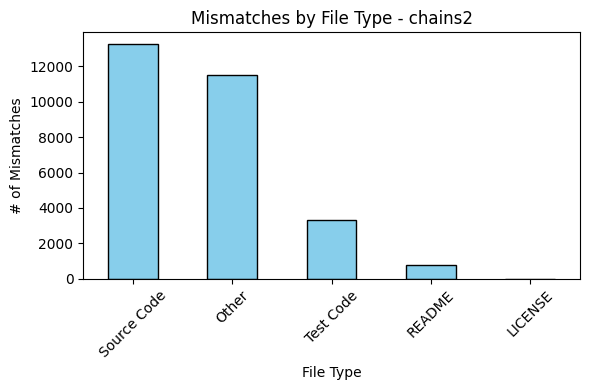

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

repositories = ["axios2", "Alamofire2", "chains2"]

def categorize_file(path: str):
    if pd.isna(path):
        return "Other"
    path = path.lower()
    if path.endswith((".py", ".java", ".cpp", ".c", ".js", ".ts")):
        return "Source Code"
    elif "test" in path or path.startswith("test") or "/test/" in path:
        return "Test Code"
    elif "readme" in path:
        return "README"
    elif "license" in path:
        return "LICENSE"
    else:
        return "Other"

for repo in repositories:
    df = pd.read_csv(f"/kaggle/working/diff_analysis_{repo}_with_discrepancy.csv")
    print(df.head())
    mismatches = df[df["Discrepancy"] == "Yes"]
    mismatches["FileType"] = mismatches["new_file_path"].apply(categorize_file)

    stats = mismatches["FileType"].value_counts()

    print(f"\nMismatch Statistics for {repo}:")
    print(stats)

    plt.figure(figsize=(6,4))
    stats.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title(f"Mismatches by File Type - {repo}")
    plt.xlabel("File Type")
    plt.ylabel("# of Mismatches")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()